# **Задание Pro**

1. Сделайте самостоятельно довольно мощную свёрточную сеть для Cifar10.

2. Добейтесь, чтобы ГА сделал точность на проверочной заметно выше, чем у вашей сети.

3. Для скорости можно использовать для обучения первые 1000 картинок и для проверки следующие 200 картинок.

Подсказка: в стартовую популяцию можно добавить вашу сеть или около 10 вариаций с небольшими отклонениями от неё, но лучше не всю популяцию делать вариациями от неё, чтобы у ГА была вариативность.

# Подключение библиотек

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import MAE
from tensorflow.keras.utils import plot_model
from tensorflow.keras import utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Поготовка данных 

In [ ]:
# Для начала загрузим базу cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

In [ ]:
# Разделим обучающую выборку на (обучающую и проверочную). Чтобы не задействовать тестовую во время обучения
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
# Посмотрим на размр выборок
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(40000, 1)
(10000, 1)
(10000, 1)


In [ ]:
# Преобразуем ответы y_train, y_val и y_test в ohe
y_train = utils.to_categorical (y_train,10)
y_val = utils.to_categorical (y_val,10)
y_test = utils.to_categorical (y_test,10)

# Посмотрим на размерность получившихся массивов 
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(40000, 10)
(10000, 10)
(10000, 10)


In [ ]:
x_train = x_train[:2000]
y_train = y_train[:2000]

x_val = x_val[:200]
y_val = y_val[:200]

x_test = x_test[:200]
y_test = y_test[:200]

# Создание базовой нейронной сети (для сравнения)

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Обучаем сеть на данных cifar10 и сохраняем результат в переменной history
history = model.fit(x_train, y_train,  batch_size=128, epochs=30, validation_data=(x_val, y_val), verbose=1)

print()
print(f"Ошибка на тестовой выборке  : {round(history.history['val_loss'][-1], 4)}")
print(f"Точность на тестовой выборке: {100 * round(history.history['val_accuracy'][-1], 2)} %")

Epoch 1/30
16/16 [==============================] - 10s 58ms/step - loss: 3.0252 - accuracy: 0.1745 - val_loss: 3.2980 - val_accuracy: 0.1000
Epoch 2/30
16/16 [==============================] - 0s 19ms/step - loss: 1.9643 - accuracy: 0.2785 - val_loss: 2.2292 - val_accuracy: 0.1600
Epoch 3/30
16/16 [==============================] - 0s 19ms/step - loss: 1.7929 - accuracy: 0.3605 - val_loss: 2.1698 - val_accuracy: 0.1950
Epoch 4/30
16/16 [==============================] - 0s 19ms/step - loss: 1.7068 - accuracy: 0.3840 - val_loss: 2.0971 - val_accuracy: 0.2000
Epoch 5/30
16/16 [==============================] - 0s 19ms/step - loss: 1.5790 - accuracy: 0.4230 - val_loss: 1.9287 - val_accuracy: 0.2650
Epoch 6/30
16/16 [==============================] - 0s 20ms/step - loss: 1.5726 - accuracy: 0.4340 - val_loss: 1.9094 - val_accuracy: 0.3050
Epoch 7/30
16/16 [==============================] - 0s 19ms/step - loss: 1.4747 - accuracy: 0.4575 - val_loss: 1.9519 - val_accuracy: 0.2750
Epoch 8/30
1

# Подбор архитектуры с помощью ГА

## Функции

In [ ]:
# Функция получения родителей
def getParents(curr_popul, nsurv):
  indexp1 = random.randint(0, nsurv - 1)
  indexp2 = random.randint(0, nsurv - 1)
  botp1 = curr_popul[indexp1]
  botp2 = curr_popul[indexp2]
  return botp1, botp2

In [ ]:
# Функция смешивания (кроссинговера) двух родителей
def crossPointFrom2Parents(botp1, botp2, j):
  index = random.random()
  if index < 0.5:
    x = botp1[j]
  else:
    x = botp2[j]
  return x

In [ ]:
# Функция результат прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

In [ ]:
# Функция визуализации графиков
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значения')
  plt.legend()
  plt.show()

In [ ]:
# Функция расёта корреляции
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a * b).mean()
  sa = a.std()
  sb = b.std()
  val = 0
  if ((sa > 0) & (sb > 0)):
    val = (mab - ma * mb) / (sa * sb)
  return val

In [ ]:
# Функция отображения корреляцию прогнозированного сигнала с правильным
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf=True, returnData=False):
  for ch in channels:
    yLen = yValUnscaled.shape[0]

    corr = []
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i, ch], predVal[i:, ch]))
    
    own_corr = []
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i, ch], yValUnscaled[i:, ch]))
    
    if showGraf:
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')
  
  if showGraf:
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
  
  if returnData:
    return corr, own_corr

In [ ]:
# Функция создания списка случайных параметров с учетом задания
def createRandomNet():
  net = []
  net.append(random.randint(0,1))   # 0  - Будет ли Нормализация 0,1
  net.append(random.randint(3,8))   # 1  - Первый свёрточный слой 2 ** (3,4,5,6,7,8) - 8, 16, 32, 64, 128, 256 - фильтров
  net.append(random.randint(2,6))   # 2  - Ядро первого свёрточного слоя (2,3,4,5,6)
  net.append(random.randint(0,4))   # 3  - Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))   # 4  - Будет ли Dropout 0,1
  net.append(random.randint(0,3))   # 5  - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  net.append(random.randint(0,1))   # 6  - Будет ли MaxPooling 0,1 


  net.append(random.randint(1,3))   # 7  - Определяем кол-во последовательных слоев от 1 до 3 Conv1D (слои будут создаваться в цикле)
  net.append(random.randint(0,1))   # 8  - Будет ли Нормализация 0,1
  net.append(random.randint(3,8))   # 9 - Кол-во фильтров в последующий Conv1D слоях 2 ** (3,4,5,6,7,8) - 8, 16, 32, 64, 128, 256 - фильтров
  net.append(random.randint(2,6))   # 10 - Ядро первого свёрточного слоя (2,3,4,5,6)
  net.append(random.randint(0,4))   # 11 - Функция активации следующих слоев - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))   # 12 - Будет ли Dropout 0,1
  net.append(random.randint(0,3))   # 13 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  net.append(random.randint(0,1))   # 14 - Будет ли MaxPooling 0,1 

  net.append(random.randint(1,3))   # 15 - Определяем кол-во Dense слоев от 1 до 4 (слои будут создаваться в цикле)
  net.append(random.randint(0,1))   # 16 - Будет ли Нормализация 0,1
  net.append(random.randint(3,10))  # 17 - Кол-во нейронов в Dense слое  2 ** (3,4,5,6,7,8,9,10) - 8, 16, 32, 64, 128, 256, 512, 1024
  net.append(random.randint(0,4))   # 18  - Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))   # 19  - Будет ли Dropout 0,1
  net.append(random.randint(0,3))   # 20  - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  net.append(random.randint(0,4))   # 21  - Функция активации выходного слоя - ['linear','relu','tanh','softmax','sigmoid']
  
  return net

In [ ]:
# Функция создания модели
def createConvNet(net):

  makeFirstNormalization = net[0]      # 0 - Нормализация в начале 0,1
  firstConvSize = 2 ** net[1]          # 1 - Первый Conv1D от 8 до 256 нейронов
  firstConvKernel = net[2]             # 2 - Ядро первого Conv1D - 2,3,4,5,6
  activation1 = net[3]                 # 3 - Функция активации, первого слоя ['linear','relu','tanh','softmax','sigmoid']
  makeDropOut1 = net[4]                # 4 - Будет ли Dropout 0,1
  firstDropout = net[5]                # 5 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  makePool1 = net[6]                   # 6  - Будет ли MaxPooling 0,1
  #firstMaxPoolKernel = net[7]         #    - Ядро свертки MaxPooling
 
  nextLayersConv1D = net[7]            # 7  - Определяем кол-во последовательных слоев от 1 до 4 Conv1D (слои будут создаваться в цикле)
  makeConvNormalization = net[8]       # 8  - Будет ли Нормализация 0,1
  secondConvSize = 2 ** net[9]         # 9 - Кол-во фильтров в последующий Conv1D слоях 2 ** (3,4,5,6,7,8) - 8, 16, 32, 64, 128, 256 - фильтров
  secondConvKernel = net[10]           # 10 - Ядро первого свёрточного слоя (2,3,4,5,6)
  activation2 = net[11]                # 11 - Функция активации следующих слоев - ['linear','relu','tanh','softmax','sigmoid']
  makeDropOut2 = net[12]               # 12 - Будет ли Dropout 0,1
  secondDropout = net[13]              # 13 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  makePool2 = net[14]                  # 14 - Будет ли MaxPooling 0,1 
  #secondMaxPoolKernel = net[16]       #    - Ядро свертки MaxPooling

  nextLayersDense = net[15]            # 15 - Определяем кол-во Dense слоев от 1 до 4 (слои будут создаваться в цикле)
  makeDenseNormalization = net[16]     # 16 - Будет ли Нормализация 0,1
  sizeDense = net[17]                  # 17 - Кол-во нейронов в Dense слое  2 ** (3,4,5,6,7,8,9,10) - 8, 16, 32, 64, 128, 256, 512, 1024
  activation3 = net[18]                # 18  - Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  makeDropout3 = net[19]               # 19  - Будет ли Dropout 0,1
  thirdDropout = net[20]               # 20  - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  activation4 = net[21]                # 21  - Функция активации выходного слоя - ['linear','relu','tanh','softmax','sigmoid']
 
  shape = (32, 32, 3)
  inputs = Input(shape)

  activation_list = ['linear', 'relu', 'tanh', 'softmax', 'sigmoid']
  dropout_list = [0.25, 0.3, 0.35, 0.4]

  if makeFirstNormalization:
    x = BatchNormalization()(inputs)
    x = Conv2D(firstConvSize, firstConvKernel, padding='same')(x)
    x = Activation(activation_list[activation1])(x)
  else:
    x = Conv2D(firstConvSize, firstConvKernel, padding='same')(inputs)
    x = Activation(activation_list[activation1])(x)
  
  if makeDropOut1:
    x = Dropout(dropout_list[firstDropout])(x)
  
  if makePool1:
    x = MaxPooling2D(2)(x)

  
  # Цикл для добавления произвольных слоев Conv1D

  for i in range(nextLayersConv1D):    # Добавляем следующие Conv1D слои с помощью цикла

    if makeConvNormalization:
      x = BatchNormalization()(x)

    x = Conv2D(secondConvSize, secondConvKernel, padding='same')(x)
    x = Activation(activation_list[activation2])(x)

    if makeDropOut2:
      x = Dropout(dropout_list[secondDropout])(x) 
    
    if makePool2:
      x = MaxPooling2D(2)(x)

  x = Flatten()(x)

  for i in range(nextLayersDense):
    if makeDenseNormalization:
      x = BatchNormalization()(x)
    
    x = Dense(2**sizeDense)(x)
    x = Activation(activation_list[activation3])(x)

    if makeDropout3:
      x = Dropout(dropout_list[thirdDropout])(x) 
      

  fin = Dense(10)(x)
  fin = Activation(activation_list[activation4])(fin)

  model = Model(inputs, fin)
  return model

In [ ]:
# Функция вычисления результата

def evaluateNet(net, ep=10, verb=False):
  val = 0
  model = createConvNet(net)
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  history = model.fit(x_train, y_train,  batch_size=128, epochs=ep, validation_data=(x_val, y_val), verbose=verb)
  val = history.history['val_accuracy'][-1]

  return val

## Реализация алгоритма

In [ ]:
n = 20           # Общее число ботов
nsurv = 5        # Кол-во выживших
nnew = n - nsurv # Кол-во новых
l = 22           # Размер бота
epochs = 15      # Количество эпох

mut = 0.1       # Коэфициент мутаций

In [ ]:
start_time = time.time()
popul = []
val = []

# Создаем случайных ботов
popul = [createRandomNet() for _ in range(n)]

for ep in range(epochs):
  val = []
  curr_time = time.time()

  print(f"Эпоха {ep}:")
  
  for i in range(n):
    bot = popul[i]
    f = evaluateNet(bot, 30)
    print(f"Бот: {i} готов")
    val.append(f)
  
  # Сортируем val
  sval = sorted(val, reverse=True)

  # Вывод
  end_time = time.time() - curr_time
  print(f'{ep} время: {round(end_time, 2)} ---- Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:2]}')

  newpopul = [] # Новая популяция
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet()

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)

  popul = newpopul

total_end_time = time.time() - start_time
print(f"Общее время обучения составило: {round(total_end_time / 60 , 2)} минут(ы)")

Эпоха 0:
Бот: 0 готов
Бот: 1 готов
Бот: 2 готов
Бот: 3 готов
Бот: 4 готов
Бот: 5 готов
Бот: 6 готов
Бот: 7 готов
Бот: 8 готов
Бот: 9 готов
Бот: 10 готов
Бот: 11 готов
Бот: 12 готов
Бот: 13 готов
Бот: 14 готов
Бот: 15 готов
Бот: 16 готов
Бот: 17 готов
Бот: 18 готов
Бот: 19 готов
0 время: 1145.23 ---- Лучшие результаты: [0.41499999165534973, 0.4050000011920929, 0.26499998569488525, 0.25999999046325684, 0.24500000476837158]  ----- Лучшие боты: [[0, 8, 2, 0, 0, 0, 1, 3, 0, 7, 5, 0, 0, 1, 1, 1, 0, 8, 4, 1, 0, 0], [0, 4, 3, 2, 0, 3, 0, 3, 1, 6, 4, 4, 1, 3, 1, 1, 1, 7, 3, 0, 1, 2]]
Эпоха 1:
Бот: 0 готов
Бот: 1 готов
Бот: 2 готов
Бот: 3 готов
Бот: 4 готов
Бот: 5 готов
Бот: 6 готов
Бот: 7 готов
Бот: 8 готов
Бот: 9 готов
Бот: 10 готов
Бот: 11 готов
Бот: 12 готов
Бот: 13 готов
Бот: 14 готов
Бот: 15 готов
Бот: 16 готов
Бот: 17 готов
Бот: 18 готов
Бот: 19 готов
1 время: 851.36 ---- Лучшие результаты: [0.4050000011920929, 0.38999998569488525, 0.38999998569488525, 0.33000001311302185, 0.3300000131130

## Проверка результатов

In [ ]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[0, 5, 3, 3, 1, 2, 1, 1, 0, 7, 4, 1, 1, 3, 1, 2, 0, 7, 4, 1, 1, 4]
[0, 5, 3, 3, 1, 2, 1, 1, 0, 7, 4, 1, 1, 3, 1, 2, 0, 7, 4, 1, 1, 4]
[0, 5, 3, 3, 1, 2, 1, 1, 0, 7, 4, 1, 1, 3, 1, 2, 0, 7, 4, 1, 1, 4]


## Обучение лучшей модели

In [ ]:
model = createConvNet(popul[0])

### Архитектура сети

In [ ]:
model.summary()

Model: "model_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_301 (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_641 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_1567 (Activation  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout_967 (Dropout)       (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_500 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_642 (Conv2D)         (None, 16, 16, 128)       65

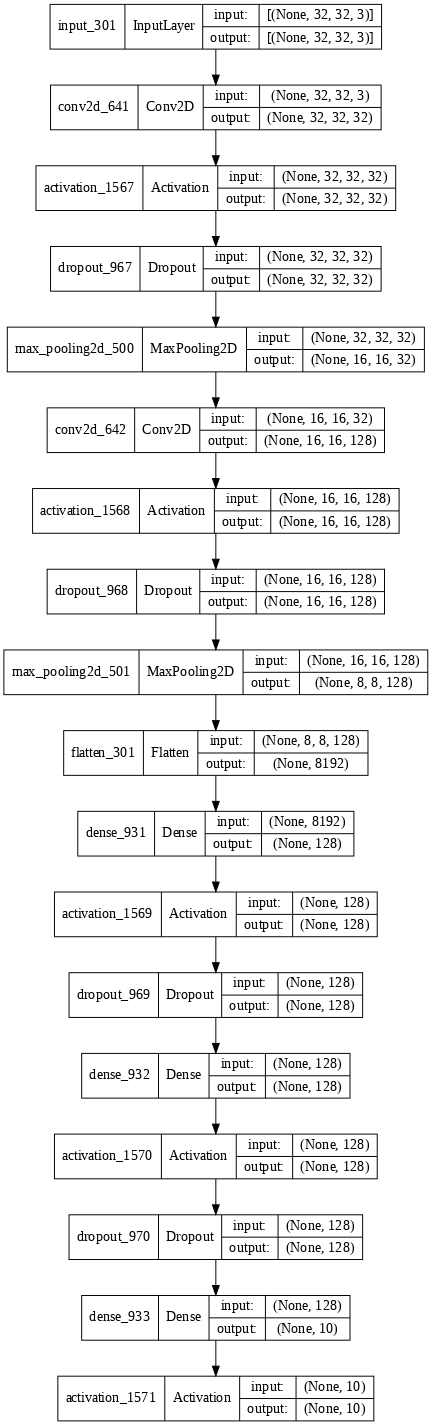

In [ ]:
plot_model(model, show_shapes=True, dpi = 70)

### Обучение

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train,  batch_size=128, epochs=50, validation_data=(x_val, y_val), verbose=1)

print()
print(f"Ошибка на тестовой выборке  : {round(history.history['val_loss'][-1], 4)}")
print(f"Точность на тестовой выборке: {100 * round(history.history['val_accuracy'][-1], 2)} %")

Epoch 1/50
313/313 [==============================] - 14s 36ms/step - loss: 1.8666 - accuracy: 0.3021 - val_loss: 1.4808 - val_accuracy: 0.4709
Epoch 2/50
313/313 [==============================] - 9s 29ms/step - loss: 1.4192 - accuracy: 0.4859 - val_loss: 1.1945 - val_accuracy: 0.5707
Epoch 3/50
313/313 [==============================] - 8s 26ms/step - loss: 1.2160 - accuracy: 0.5649 - val_loss: 1.0975 - val_accuracy: 0.6138
Epoch 4/50
313/313 [==============================] - 8s 26ms/step - loss: 1.0946 - accuracy: 0.6097 - val_loss: 1.0424 - val_accuracy: 0.6296
Epoch 5/50
313/313 [==============================] - 8s 26ms/step - loss: 1.0093 - accuracy: 0.6428 - val_loss: 0.9726 - val_accuracy: 0.6555
Epoch 6/50
313/313 [==============================] - 8s 26ms/step - loss: 0.9500 - accuracy: 0.6658 - val_loss: 0.9472 - val_accuracy: 0.6671
Epoch 7/50
313/313 [==============================] - 8s 26ms/step - loss: 0.8878 - accuracy: 0.6874 - val_loss: 0.9635 - val_accuracy: 0.659

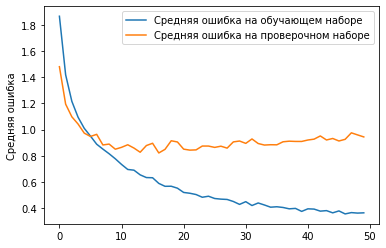

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# Определение изображений из тестовой выборки

In [ ]:
classes = {0:'Самолет', 
           1:'Автомобиль',
           2:'Птица',
           3:'Кошка',
           4:'Олень',
           5:'Собака',
           6:'Лягушка',
           7:'Лошадь',
           8:'Корабль',
           9:'Грузовик'}

Распознанный браз на картинке:  Грузовик


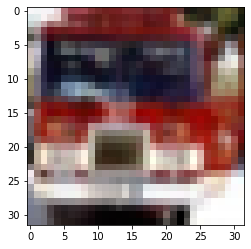


Распознанный браз на картинке:  Лягушка


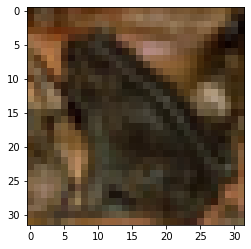


Распознанный браз на картинке:  Самолет


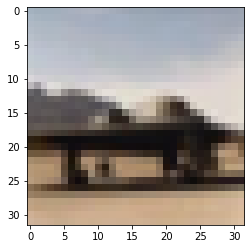


Распознанный браз на картинке:  Самолет


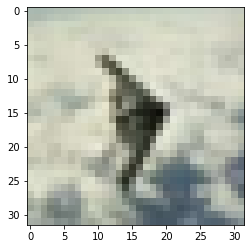


Распознанный браз на картинке:  Кошка


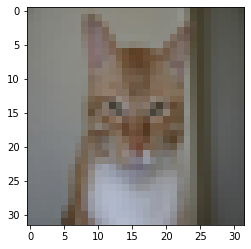


Распознанный браз на картинке:  Самолет


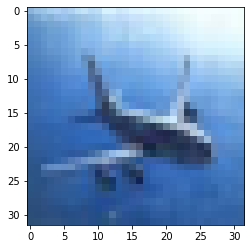


Распознанный браз на картинке:  Самолет


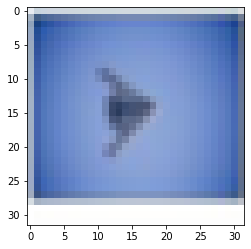


Распознанный браз на картинке:  Птица


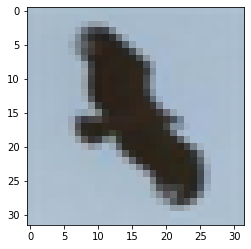


Распознанный браз на картинке:  Олень


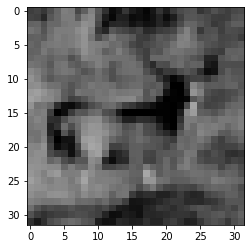


Распознанный браз на картинке:  Собака


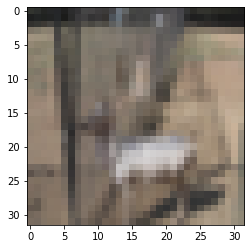

In [ ]:
#Распознаём все тестовые картинки
prediction = model.predict(x_test)

#Выбираем номер примера
for _ in range(10):
  n = np.random.randint(x_test.shape[0])

  #Выводим на экран результаты
  print("Распознанный браз на картинке: ", classes[np.argmax(prediction[n])])

  #Выводим на экран картинку
  plt.imshow(Image.fromarray(x_test[n]).convert('RGBA'))
  plt.show()
  print()



# Выводы:

1. Используя **Генетические алгоритмы** можно подобрать более лучшую архитектуру и гиперпараметры для конкретных задач.
2. Так же использования **ГА** для обучения нейронных сетей экономится время для перебора.
3. Для лучшего результата требуется использовать весь обучающий набор, что значительно увеличивает время.
4. Можно перебирать параметры на меньшем датасете, найти лучший резльтат. И тогда уже обучать на полных данных. 
5. С помощью **ГА** удалось подобрать архитектуру и гипермараметры с лучшей точностью. 
6. После проделанной работы больше понимания как работаю **ГА**. А так же сколько требутся времени на обучение. 
7. Так же будет полезно для решения других более сложных задач.